In [1]:
library(MASS)
library(tidyverse)
library(statsr)
library(BAS)
library(broom)

options(width=100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
Loading required package: BayesFactor
Loading required package: coda
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************


In [2]:
data(wage)

In [3]:
set.seed(18383)

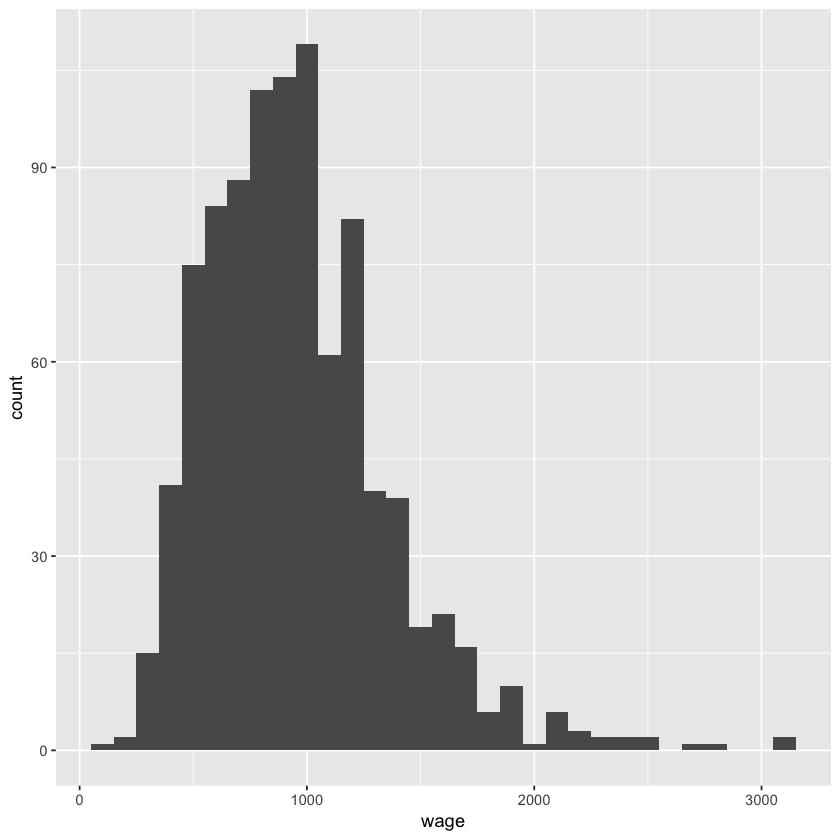

In [4]:
ggplot(data = wage, aes(x = wage)) +
  geom_histogram(binwidth = 100)

In [5]:
summary(wage$wage)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  115.0   669.0   905.0   957.9  1160.0  3078.0 

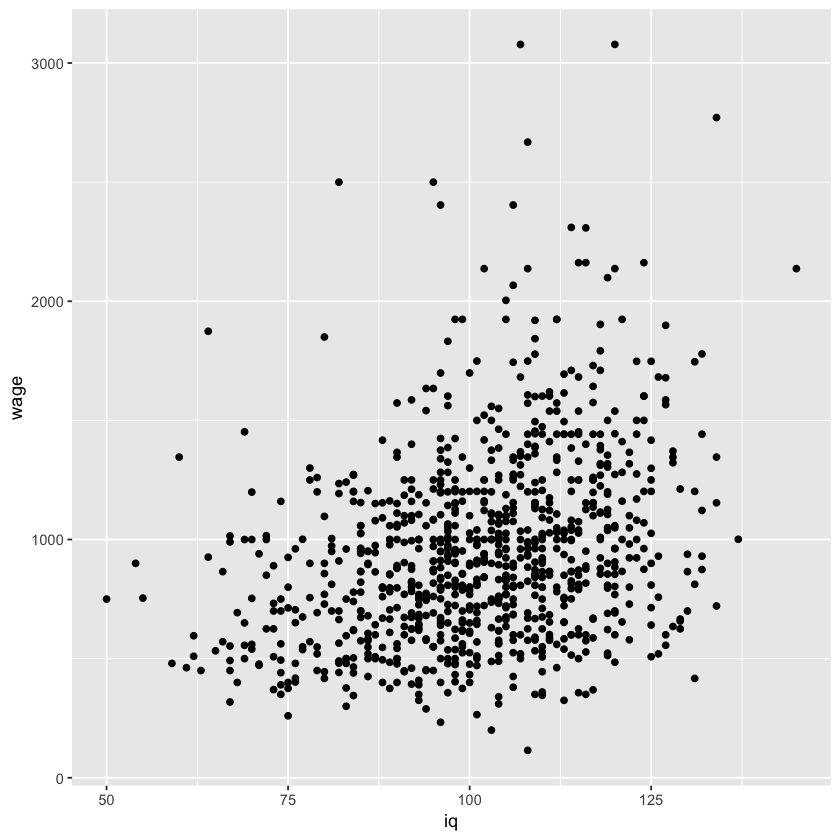

In [6]:
ggplot(data = wage, aes(x = iq, y = wage)) +
  geom_point()

In [8]:
m_wage_iq <- lm(wage ~ iq, data = wage)

In [9]:
tidy(m_wage_iq)

term,estimate,std.error,statistic,p.value
(Intercept),116.991565,85.6415293,1.366061,1.722489e-01
iq,8.303064,0.8363951,9.927203,3.794935e-22


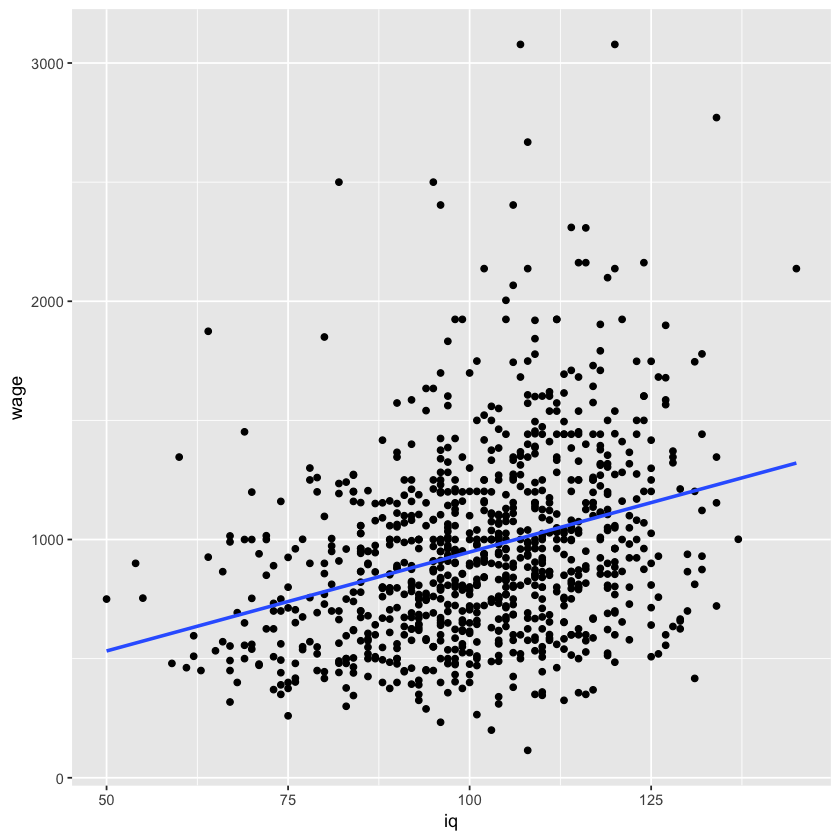

In [10]:
ggplot(data = wage, aes(x = iq, y = wage)) +
  geom_point() +
  stat_smooth(method = "lm", se = FALSE)

In [11]:
confint(m_wage_iq)

,2.5 %,97.5 %
(Intercept),-51.080781,285.063910
iq,6.661631,9.944498


In [12]:
m_wage_iq_aug <- augment(m_wage_iq)

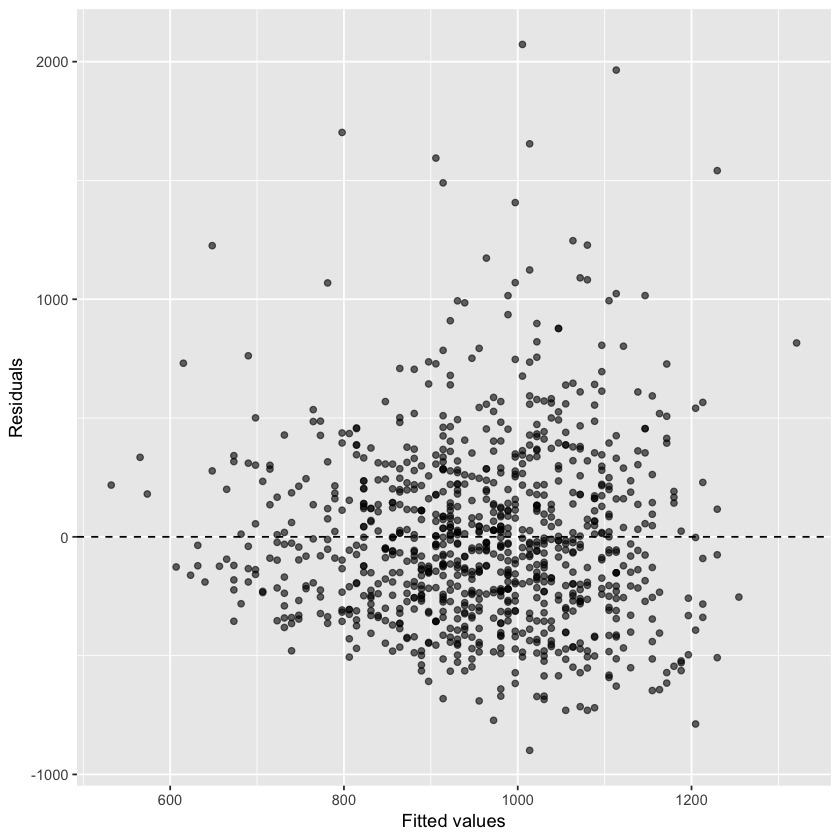

In [13]:
ggplot(data = m_wage_iq_aug, aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "Fitted values", y = "Residuals")

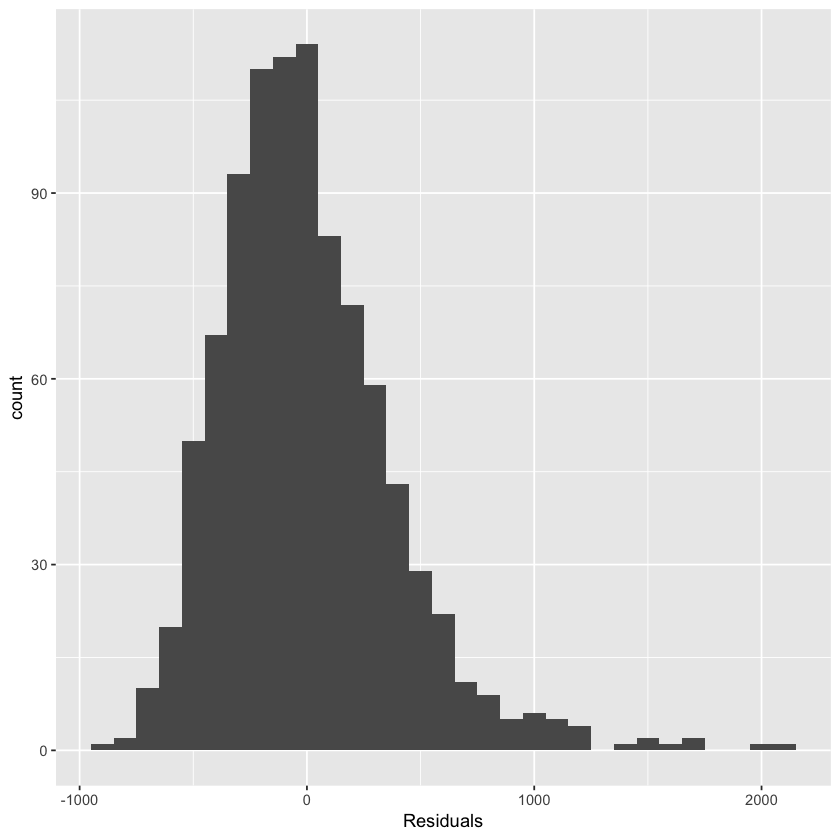

In [14]:
ggplot(data = m_wage_iq_aug, aes(x = .resid)) +
  geom_histogram(binwidth = 100) +
  xlab("Residuals")

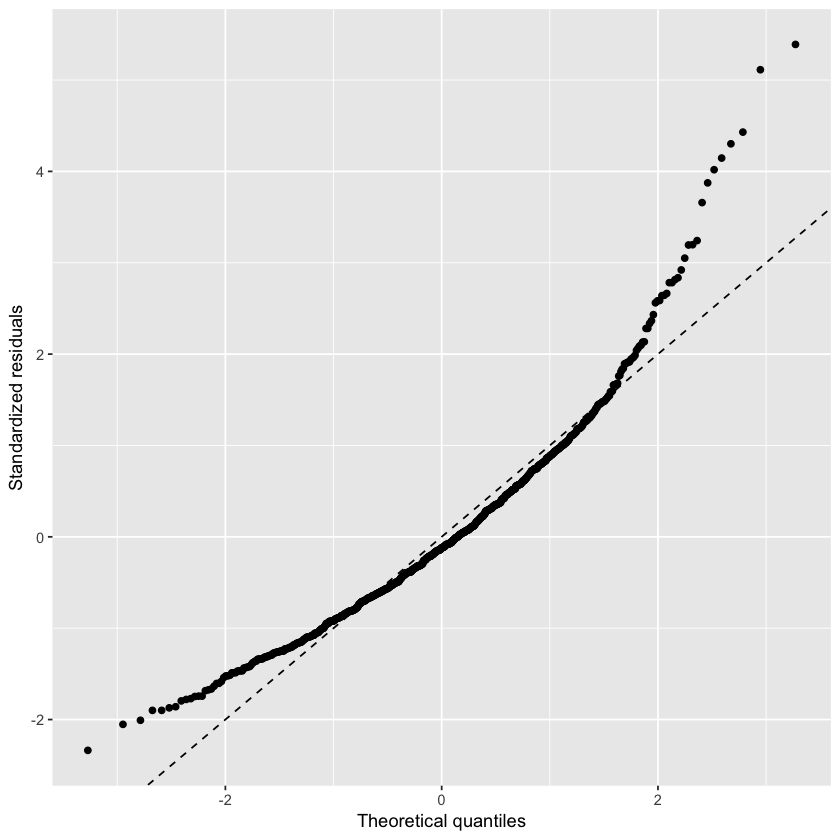

In [15]:
ggplot(m_wage_iq_aug) +
  geom_qq(aes(sample = .std.resid)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(x = "Theoretical quantiles", y = "Standardized residuals")

In [16]:
m_lwage_iq = lm(lwage ~ iq, data = wage)

In [20]:
outliers <- Bayes.outlier(m_lwage_iq, k = 3)

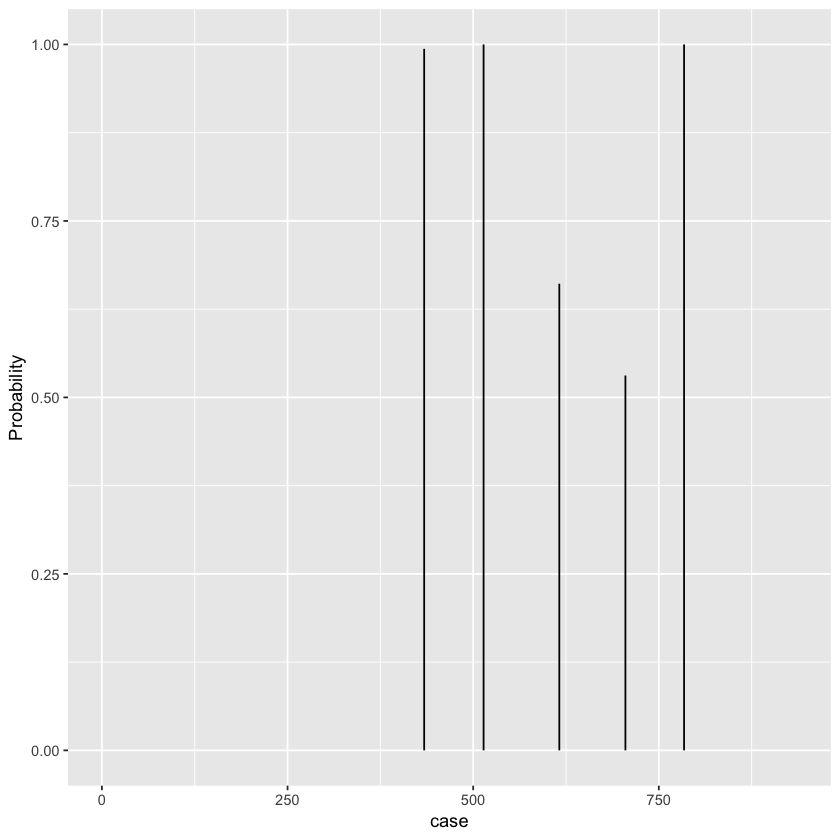

In [22]:
outliers_df <- data.frame(
    probability = outliers$prob.outlier,
    case = 1:length(outliers$prob.outlier)
)

ggplot(
    outliers_df,
    aes(ymax = probability, x = case)
) +
  geom_linerange(ymin = 0) +
  labs(y = "Probability")

In [23]:
outliers_df %>%
  filter(probability > 0.50)

probability,case
0.9937375,434
1.0000000,514
0.6610078,616
0.5309985,705
1.0000000,784


In [24]:
# prob of a case being an outlier:
#   being below or above 3 standard deviations from 0
(prob_outlier <- pnorm(-3) + pnorm(3, lower.tail = FALSE))

[1] 0.002699796

In [26]:
# probability of a signle case not being an outler is therefore the complement 
(prob_not_outlier <- 1 - prob_outlier)

[1] 0.9973002

In [27]:
# probability of no outliers in the sample of n assuming errors are independent a priori
n <- nrow(wage)
(prob_no_outliers <- prob_not_outlier^n)

[1] 0.07984061

In [28]:
# probability of at least one outlier in the sample is the complement of the 
# probability of no outliers in the sample of n
1 - prob_no_outliers

[1] 0.9201594

In [29]:
n <- nrow(wage)
(prob_obs_not_outlier <- 0.95^(1/n))

[1] 0.9999451

In [31]:
(newk <- qnorm(0.5 + 0.5 * prob_obs_not_outlier))

[1] 4.033904

In [32]:
outliers <- Bayes.outlier(m_lwage_iq, prior.prob=0.95)

In [33]:
m_lwage_full <- lm(lwage ~ . - wage, data = wage)

In [34]:
BIC(m_lwage_full)

[1] 586.3732

In [35]:
m_lwage_nobrthord <- lm(
    lwage ~ . - wage - brthord,
    data = na.omit(wage)
)
BIC(m_lwage_nobrthord)

[1] 582.4815

In [37]:
# Exclude observations with missing values in the data set
wage_no_na <- na.omit(wage)

# Fit the model using Bayesian linear regression, `bas.lm` function in the `BAS` package
bma_lwage <- bas.lm(lwage ~ . -wage, data = wage_no_na,
                   prior = "BIC", 
                   modelprior = uniform())

# Print out the marginal posterior inclusion probabilities for each variable                
bma_lwage


Call:
bas.lm(formula = lwage ~ . - wage, data = wage_no_na, prior = "BIC", 
    modelprior = uniform())


 Marginal Posterior Inclusion Probabilities: 
Intercept      hours         iq        kww       educ      exper     tenure        age   married1  
  1.00000    0.85540    0.89732    0.34790    0.99887    0.70999    0.70389    0.52468    0.99894  
   black1     south1     urban1       sibs    brthord      meduc      feduc  
  0.34636    0.32029    1.00000    0.04152    0.12241    0.57339    0.23274  

In [38]:
# Top 5 most probably models
summary(bma_lwage)

,P(B != 0 | Y),model 1,model 2,model 3,model 4,model 5
Intercept,1.00000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
hours,0.85540453,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
iq,0.89732383,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
kww,0.34789688,0.0000,0.0000000,0.0000000,1.0000000,0.0000000
educ,0.99887165,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
exper,0.70999255,0.0000,1.0000000,1.0000000,1.0000000,0.0000000
tenure,0.70388781,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
age,0.52467710,1.0000,1.0000000,0.0000000,0.0000000,1.0000000
married1,0.99894488,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
black1,0.34636467,0.0000,0.0000000,0.0000000,0.0000000,1.0000000


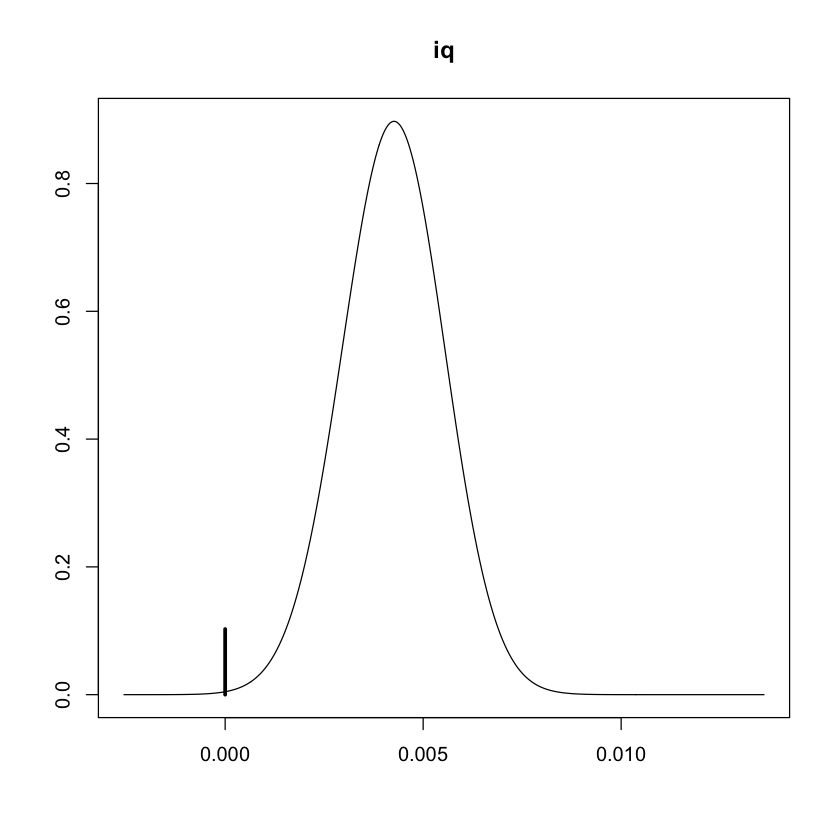

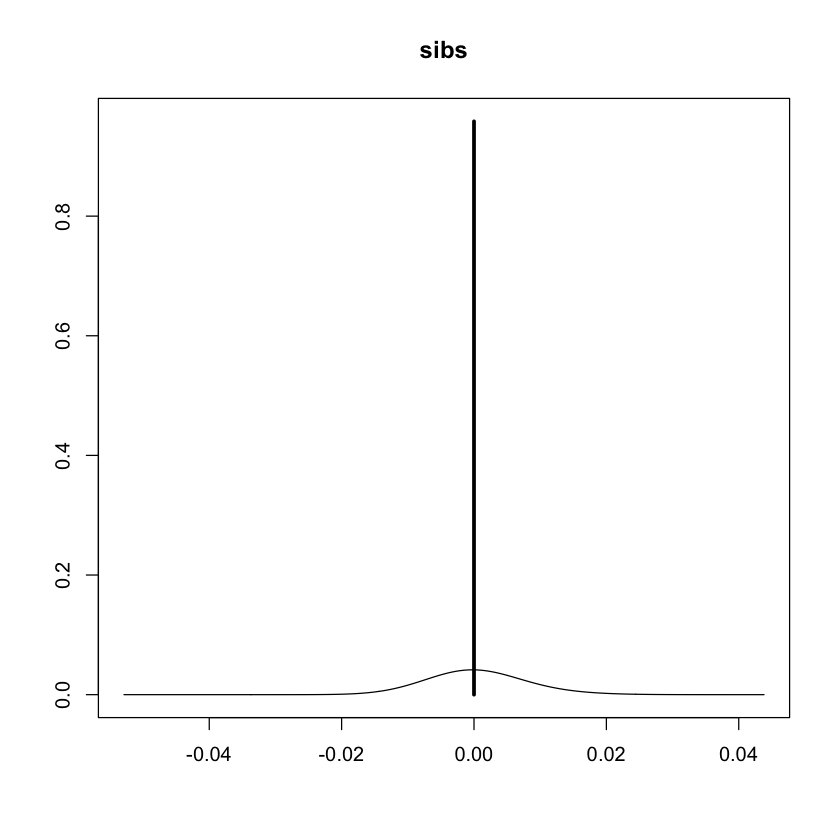

In [39]:
# Obtain the coefficients from the model `bma_lwage`
coef_lwage <- coefficients(bma_lwage)

# `iq` is the 3rd variable, while `sibs` is the 13th variable in the data set
plot(coef_lwage, subset = c(3,13), ask = FALSE)

In [40]:
confint(coef_lwage)

                  2.5%       97.5%          beta
Intercept  6.786051335 6.839914031  6.8142970694
hours     -0.009280565 0.000000000 -0.0053079979
iq         0.000000000 0.006219927  0.0037983313
kww        0.000000000 0.008417459  0.0019605787
educ       0.022662711 0.066602328  0.0440707549
exper      0.000000000 0.021154000  0.0100264057
tenure     0.000000000 0.012808182  0.0059357058
age        0.000000000 0.025304130  0.0089659753
married1   0.117452432 0.300242810  0.2092940731
black1    -0.191166337 0.000000000 -0.0441863361
south1    -0.102021149 0.000000000 -0.0221757978
urban1     0.135668080 0.259655643  0.1981221313
sibs       0.000000000 0.000000000  0.0000218455
brthord   -0.019490332 0.000000000 -0.0019470674
meduc      0.000000000 0.022602340  0.0086717156
feduc      0.000000000 0.015636061  0.0025125930
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

In [41]:
wage_red <- wage %>%
  select(-wage, -sibs, -brthord, -meduc, -feduc)

In [42]:
bma_lwage_red <- bas.lm(lwage ~ ., data = wage_red,  
                        prior = "ZS-null",
                        modelprior = uniform())

In [43]:
coef(bma_lwage_red)


 Marginal Posterior Summaries of Coefficients: 

 Using  BMA 

 Based on the top  2048 models 
           post mean  post SD    post p(B != 0)
Intercept   6.779004   0.011815   1.000000     
hours      -0.005153   0.002011   0.948638     
iq          0.003216   0.001266   0.947570     
kww         0.002125   0.002527   0.500034     
educ        0.051663   0.007925   1.000000     
exper       0.011777   0.004362   0.951747     
tenure      0.010513   0.002490   0.998751     
age         0.002391   0.004879   0.269606     
married1    0.197358   0.038797   0.999970     
black1     -0.147152   0.044153   0.986607     
south1     -0.074443   0.033753   0.915710     
urban1      0.179091   0.027027   1.000000     

In [44]:
coef(bma_lwage_red) %>%
  confint()

                   2.5%        97.5%         beta
Intercept  6.756906e+00  6.802691363  6.779003810
hours     -8.068312e-03  0.000000000 -0.005152980
iq         0.000000e+00  0.005062757  0.003216182
kww        0.000000e+00  0.006927795  0.002124717
educ       3.610047e-02  0.067064487  0.051663021
exper      0.000000e+00  0.018075000  0.011777136
tenure     5.891053e-03  0.015492498  0.010513266
age       -1.825179e-05  0.015088202  0.002390900
married1   1.244161e-01  0.275012146  0.197358085
black1    -2.323964e-01 -0.062394164 -0.147151969
south1    -1.227845e-01  0.000000000 -0.074442861
urban1     1.256593e-01  0.231024653  0.179091430
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

In [45]:
ci_urban <- coef(bma_lwage_red) %>%
  confint(parm = "urban1") %>%
  exp()

ci_urban

           2.5%    97.5%    beta
urban1 1.134622 1.260947 1.19613
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

In [46]:
(ci_urban - 1) * 100

           2.5%    97.5%     beta
urban1 13.46219 26.09468 19.61301
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

In [47]:
BPM_pred_lwage <- predict(bma_lwage, estimator = "BPM", se.fit = TRUE)
variable.names(BPM_pred_lwage)

[1] "Intercept" "hours"     "iq"        "kww"       "educ"      "exper"     "tenure"    "age"      
 [9] "married1"  "urban1"    "meduc"

In [48]:
HPM_pred_lwage <- predict(bma_lwage, estimator = "HPM")
variable.names(HPM_pred_lwage)

[1] "Intercept" "hours"     "iq"        "educ"      "tenure"    "age"       "married1"  "urban1"   
[9] "meduc"

In [49]:
MPM_pred_lwage <- predict(bma_lwage, estimator = "MPM")
variable.names(MPM_pred_lwage)

[1] "Intercept" "hours"     "iq"        "educ"      "exper"     "tenure"    "age"       "married1" 
 [9] "urban1"    "meduc"

In [50]:
# Find the index of observation with the largest fitted value
opt <- which.max(BPM_pred_lwage$fit)

# Extract the row with this observation and glimpse at the row
wage_no_na %>% 
  slice(opt) %>%
  glimpse()

Observations: 1
Variables: 17
$ wage    <int> 1586
$ hours   <int> 40
$ iq      <int> 127
$ kww     <int> 48
$ educ    <int> 16
$ exper   <int> 16
$ tenure  <int> 12
$ age     <int> 37
$ married <fct> 1
$ black   <fct> 0
$ south   <fct> 0
$ urban   <fct> 1
$ sibs    <int> 4
$ brthord <int> 4
$ meduc   <int> 16
$ feduc   <int> 16
$ lwage   <dbl> 7.36897


In [51]:
ci_lwage <- confint(BPM_pred_lwage, parm = "pred")
ci_lwage[opt,]

2.5%    97.5%     pred 
6.661865 8.056455 7.359160

In [52]:
exp(ci_lwage[opt,])

2.5%     97.5%      pred 
 782.0078 3154.0905 1570.5169

In [53]:
BMA_pred_lwage <- predict(bma_lwage, estimator = "BMA", se.fit = TRUE)
ci_bma_lwage <- confint(BMA_pred_lwage, estimator = "BMA")
opt_bma <- which.max(BMA_pred_lwage$fit)
exp(ci_bma_lwage[opt_bma, ])

2.5%     97.5%      pred 
 721.7465 3004.5320 1494.9899